# Analyze Data and Get Metabolomics Info

In [2]:
import pickle
from minedatabase.pickaxe import Pickaxe
import seaborn as sns
import pandas as pd
from copy import deepcopy, copy

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("pastel")

# Load in Data

In [3]:
pk = Pickaxe()
pk.load_pickled_pickaxe("../../kms_ecoli_metab_100t300r200.pk")

----------------------------------------
Intializing pickaxe object

Done intializing pickaxe object
----------------------------------------

Loading ../../kms_ecoli_metab_100t300r200.pk pickled data.
Loaded 29787 compounds
Loaded 56649 reactions
Loaded 50 operators
Took 0.6972930431365967


# Read in Thermo/Feasibility Results

### Read in Thermo and make into dataframe

In [4]:
dg_dict = pickle.load(open("../thermodynamic_filter/physiological_dgs.pk", "rb"))
dg_dict = {key: {"value": val.value.magnitude, "error": val.error.magnitude} for key, val in dg_dict.items()}
dg_df = pd.DataFrame.from_dict(dg_dict).T.reset_index().rename(columns = {"index": "_id"})

### Read in feasibility results and make into dataframe

In [5]:
feas_dict_gen1 = pickle.load(open("../feasibility_filter/feas_dict_g1.pk", "rb"))
feas_dict_gen2 = pickle.load(open("../feasibility_filter/feas_dict_g2.pk", "rb"))
print(f"# Reactions in Generation 1: {len(feas_dict_gen1)}")
print(f"# Reactions in Generation 2: {len(feas_dict_gen2)}")

feas_dict_gen1.update(feas_dict_gen2)

feas_list = [(key, val) for key, val in feas_dict_gen1.items()]
feas_df = pd.DataFrame(data=feas_list, columns=["_id", "feasible"])
feas_df.head()

# Reactions in Generation 1: 16202
# Reactions in Generation 2: 35346


,_id,feasible
0,Rbddc66ee89918db8d862f24c709ccccd17c1ab98d756c...,False
1,R12a79ffbaaf7d2fdb13d4fd046b8802476c9761bc1076...,True
2,R6c79d9ebdacf4f9a9251865d6e706ed3c8861c8a4fd8c...,False
3,Rdc85adcc63aa978c5747e897c46a3d8dc3792f01e6a33...,True
4,R628298201db2ef4c87e8770cd1903dfc22a4a1e0fae2c...,False


# Get Valid Compounds for Feas/Thermo Results

### Feasibility

In [6]:
feas_set = set(feas_df[feas_df["feasible"] == True].iloc[:, 0])
print(f"There are {len(feas_set)} feasible reactions out of {len(feas_df)}")

There are 14395 feasible reactions out of 50514


### Thermodynamics
For thermodynamics we both filter by the gibbs free energy AND the uncertainty associated with it.

In [7]:
max_dg = 50
max_error = 40

dg_set = set(dg_df._id)

dg_set = set(
    dg_df[
        (dg_df.value < 30)
    ]._id
)

dg_unc_set = set(
        dg_df[
    (
            (dg_df.error < 50)
            # | (dg_df.error > 200)
        )
    ]._id
)

len(dg_set)
len(dg_unc_set)

thermo_set = dg_set & dg_unc_set
print(f"There are {len(thermo_set)} feasible reactions out of {len(dg_df)}")

There are 35997 feasible reactions out of 56649


# Code to reduce Network Based on Filters

In [8]:
def reduce_pickaxe(reaction_ids_to_delete, pk):
    pickaxe = deepcopy(pk)
    compound_ids_to_check = []

    def should_delete_reaction(rxn_id: str) -> bool:
            """Whether we should delete reaction with supplied ID.

            Parameters
            ----------
            rxn_id : str
                ID of reaction.

            Returns
            -------
            bool
                True if we should delete, False otherwise.
            """
            products = pickaxe.reactions[rxn_id]["Products"]
            for _, c_id in products:
                if c_id.startswith("C") and c_id not in cpds_to_remove:
                    return False
            # Every compound isn't in cpds_to_remove
            return True

    def remove_reaction(rxn_id):
        """Remove reaction from compounds product/reactant in then delete reaction"""
        cpds_to_return = set()
        # Remove affiliations of reaction and check compounds
        product_ids = [cpd[1] for cpd in pickaxe.reactions[rxn_id]["Products"]]
        for prod_id in product_ids:
            if prod_id.startswith("C"):
                pickaxe.compounds[prod_id]["Product_of"].remove(rxn_id)
                cpds_to_return.add(prod_id)

        compound_ids = [cpd[1] for cpd in pickaxe.reactions[rxn_id]["Reactants"]]
        for cpd_id in compound_ids:
            if cpd_id.startswith("C"):
                pickaxe.compounds[cpd_id]["Reactant_in"].remove(rxn_id)
                cpds_to_return.add(cpd_id)
        
        # Delete reaction itself
        del pickaxe.reactions[rxn_id]

        return cpds_to_return

    # Process reactions to delete
    # Loop through reactions to add compounds to check and to delete reactions
    cpd_check_from_rxn = set()
    for rxn_id in reaction_ids_to_delete:
        # Remove reaction based on ID and return any compounds to be checked
        cpd_check_from_rxn = cpd_check_from_rxn.union(remove_reaction(rxn_id))
        
    i = 0
    # Check for orphaned compounds due to reactions
    while len(cpd_check_from_rxn) != 0:
        cpd_id = cpd_check_from_rxn.pop()
        i += 1
        # Orphan compound is one that has no reaction connecting it BUT NOT STARTING COMPOUNDS
        if cpd_id in pickaxe.compounds:
            # TODO Fix this
            if pickaxe.compounds[cpd_id]["Type"] == "Starting Compound":
                continue
            product_of = copy(pickaxe.compounds[cpd_id].get("Product_of", []))
            # Delete if no reactions
            if not product_of:
                # TODO Fix this copy
                # Delete out reactions
                reactant_in = copy(pickaxe.compounds[cpd_id].get("Reactant_in", []))
                for rxn_id in reactant_in:
                    cpd_check_from_rxn = cpd_check_from_rxn.union(remove_reaction(rxn_id))

                # Now delete compound
                del(pickaxe.compounds[cpd_id])

    return pickaxe

# Generate Networks based on Filter Results

### Define the filters

In [9]:
pk_rxns = set(pk.reactions)

feasibility_to_remove = pk_rxns - feas_set

thermo_dg_to_remove = pk_rxns - dg_set
thermo_unc_to_remove = pk_rxns - dg_unc_set
thermo_to_remove = pk_rxns - (dg_set | dg_unc_set)

all_filters = thermo_to_remove | feasibility_to_remove

print("Feasibility:", len(feasibility_to_remove))
print("Thermodynamics: ", len(thermo_to_remove))
print("All Filters:", len(all_filters))

Feasibility: 42254
Thermodynamics:  4584
All Filters: 43663


In [10]:
pk_feasibility = reduce_pickaxe(feasibility_to_remove, pk)
pk_thermodynamics = reduce_pickaxe(thermo_to_remove, pk)
pk_all_filters = reduce_pickaxe(all_filters, pk)

### Generate the reduced networks

In [11]:

compound_dict_list = []

runs = [("Metabolomics", pk), ("Feasibility/Met", pk_feasibility), ("Thermodynamic/Met", pk_thermodynamics), ("All", pk_all_filters)]
# runs = [("Metabolomic", pk), ("Feasibility/Met", feas_filter)]
for filter_name, pickaxe in runs:
    gen0_count = sum([cpd["Generation"] == 0 for cpd in pickaxe.compounds.values()])
    gen1_count = sum([cpd["Generation"] == 1 for cpd in pickaxe.compounds.values()])
    gen2_count = sum([cpd["Generation"] == 2 for cpd in pickaxe.compounds.values()])
    compound_dict_list.extend([
        {"Generation": "0", "type": "compounds", "Filter": filter_name, "counts": gen0_count},
        {"Generation": "1", "type": "compounds", "Filter": filter_name, "counts": gen1_count},
        {"Generation": "2", "type": "compounds", "Filter": filter_name, "counts": gen2_count},
        {"Generation": "Total", "type": "compounds", "Filter": filter_name, "counts": gen1_count+gen2_count}
    ])

In [12]:
results_df = pd.DataFrame().from_dict(compound_dict_list)
results_df

,Generation,type,Filter,counts
0,0,compounds,Metabolomics,1359
1,1,compounds,Metabolomics,4757
2,2,compounds,Metabolomics,23671
3,Total,compounds,Metabolomics,28428
4,0,compounds,Feasibility/Met,1359
5,1,compounds,Feasibility/Met,2518
6,2,compounds,Feasibility/Met,3455
7,Total,compounds,Feasibility/Met,5973
8,0,compounds,Thermodynamic/Met,1359
9,1,compounds,Thermodynamic/Met,4155


In [13]:
from matplotlib import rcParams
params = {
   'axes.labelsize': 14,
   'font.size': 14,
   'legend.fontsize': 10,
   'legend.title_fontsize': 12,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5],
   }
rcParams.update(params)

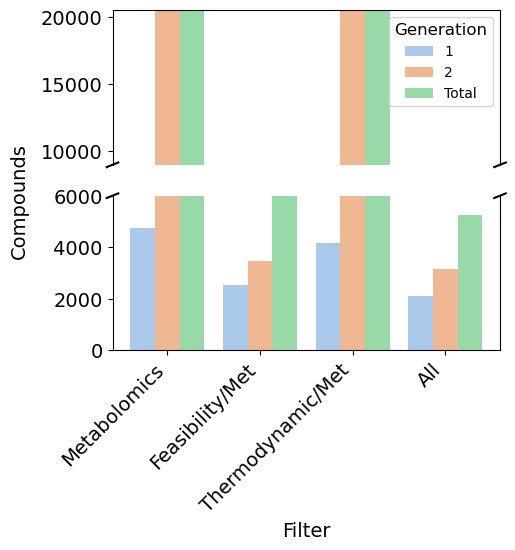

In [14]:
df = results_df[results_df.Generation != "0"]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, figsize=(5, 5), dpi=100)
g = sns.barplot(x="Filter", y="counts", hue="Generation", data=df, ax=ax)
g = sns.barplot(x="Filter", y="counts", hue="Generation", data=df, ax=ax2)

ax.set_ylim(9000, 20500)
ax.set_xlabel(None)
ax2.set_ylim(0, 6000)

# Hide spine between ax1, ax2
ax.tick_params(labeltop='off', bottom=False)  # don't put tick labels at the top
ax.spines['bottom'].set_visible(False)

ax2.get_legend().remove()
ax2.spines['top'].set_visible(False)
# ax2.xaxis.tick_bottom()


# Get diagonals drawn
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# =============
# Labels


# Common y label
ax.set_ylabel("")
ax2.set_ylabel("")
fig.text(-0.08, 0.5, 'Compounds', va='center', rotation='vertical')


# ax2.set_xticklabels(["Met", "Met/Feas", "Met/Thermo", "All"])
fig.autofmt_xdate(rotation=45)

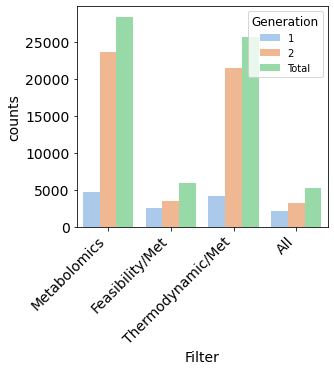

In [15]:
fig, ax = plt.subplots(1, 1)
g = sns.barplot(x="Filter", y="counts", hue="Generation", data=df)
fig.autofmt_xdate(rotation=45)
# g.set_yscale("log")

# Get Compound Peak Pairs

In [16]:

from collections import defaultdict # All
runs = [("Metabolomic", pk), ("Thermodynamic/Met", pk_thermodynamics), ("Feasibility/Met", pk_feasibility), ("All", pk_all_filters)]

count_dict = dict()
peak_dict = dict()
peak_count_dict = dict()

for run_name, run_pk in runs:
    count_dict[run_name] = {}
    hits_dict = defaultdict(set)
    for cpd in run_pk.compounds.values():
        
        if cpd["_id"].startswith("C"):
            matched_peaks = cpd.get("Matched_Peak_IDs", [])
            count_dict[run_name][cpd["Generation"]] = count_dict[run_name].get(cpd["Generation"], 0) + len(matched_peaks)

            for peak in matched_peaks:
                hits_dict[cpd["Generation"]].add(peak)

    unique_gen2 = hits_dict[2] - hits_dict[1]
    peak_dict[run_name] = hits_dict
    peak_count_dict[run_name] = {k:len(v) for k, v in hits_dict.items()}
    # peak_count_dict[run_name] = {1:len(hits_dict[1]), 2:len(hits_dict[2]-hits_dict[1])}
    peak_count_dict[run_name]["Total"] = len(peak_dict[run_name][1].union(peak_dict[run_name][2]))
    cumsum = 0
    for val in count_dict[run_name].values():
        cumsum += val
    
    count_dict[run_name]["Total"] = cumsum


count_df = pd.DataFrame.from_dict(count_dict).T.reset_index().rename(columns={"index": "Filter"})
count_df = pd.melt(count_df, id_vars=["Filter"], value_vars=[0, 1, 2, "Total"], var_name="Generation", value_name="counts")

peak_count_df = pd.DataFrame.from_dict(peak_count_dict).T.reset_index().rename(columns={"index": "Filter"})
peak_count_df = pd.melt(peak_count_df, id_vars=["Filter"], value_vars=[1, 2, "Total"], var_name="Generation", value_name="counts")

In [17]:
peak_count_dict

{'Metabolomic': {1: 54, 2: 50, 'Total': 55},
 'Thermodynamic/Met': {1: 53, 2: 50, 'Total': 54},
 'Feasibility/Met': {1: 49, 2: 43, 'Total': 49},
 'All': {1: 48, 2: 42, 'Total': 48}}

# Get Compound Counts

In [18]:
dict_list = []
from collections import Counter

for run in runs:
    cpd_count_df = Counter()
    p = run[1]

    for cpd in p.compounds.values():
        gen = cpd["Generation"]
        if gen != 0:
            cpd_count_df[gen] += 1

    for key, val in cpd_count_df.items():
        dict_list.append({"Filter": run[0], "generation": str(key), "compounds": val})

    dict_list.append({"Filter": run[0], "generation": "Total", "compounds": sum(cpd_count_df.values())})

dict_list.append({"Filter": "None", "generation": "1", "compounds": 65423}) 
dict_list.append({"Filter": "None", "generation": "2", "compounds": 2520401})      
dict_list.append({"Filter": "None", "generation": "Total", "compounds": 65423+2520401})      

df_cpd_count = pd.DataFrame(data=dict_list)
df_cpd_count

,Filter,generation,compounds
0,Metabolomic,1,4757
1,Metabolomic,2,23671
2,Metabolomic,Total,28428
3,Thermodynamic/Met,1,4155
4,Thermodynamic/Met,2,21473
5,Thermodynamic/Met,Total,25628
6,Feasibility/Met,1,2518
7,Feasibility/Met,2,3455
8,Feasibility/Met,Total,5973
9,All,1,2115


# Total Peaks

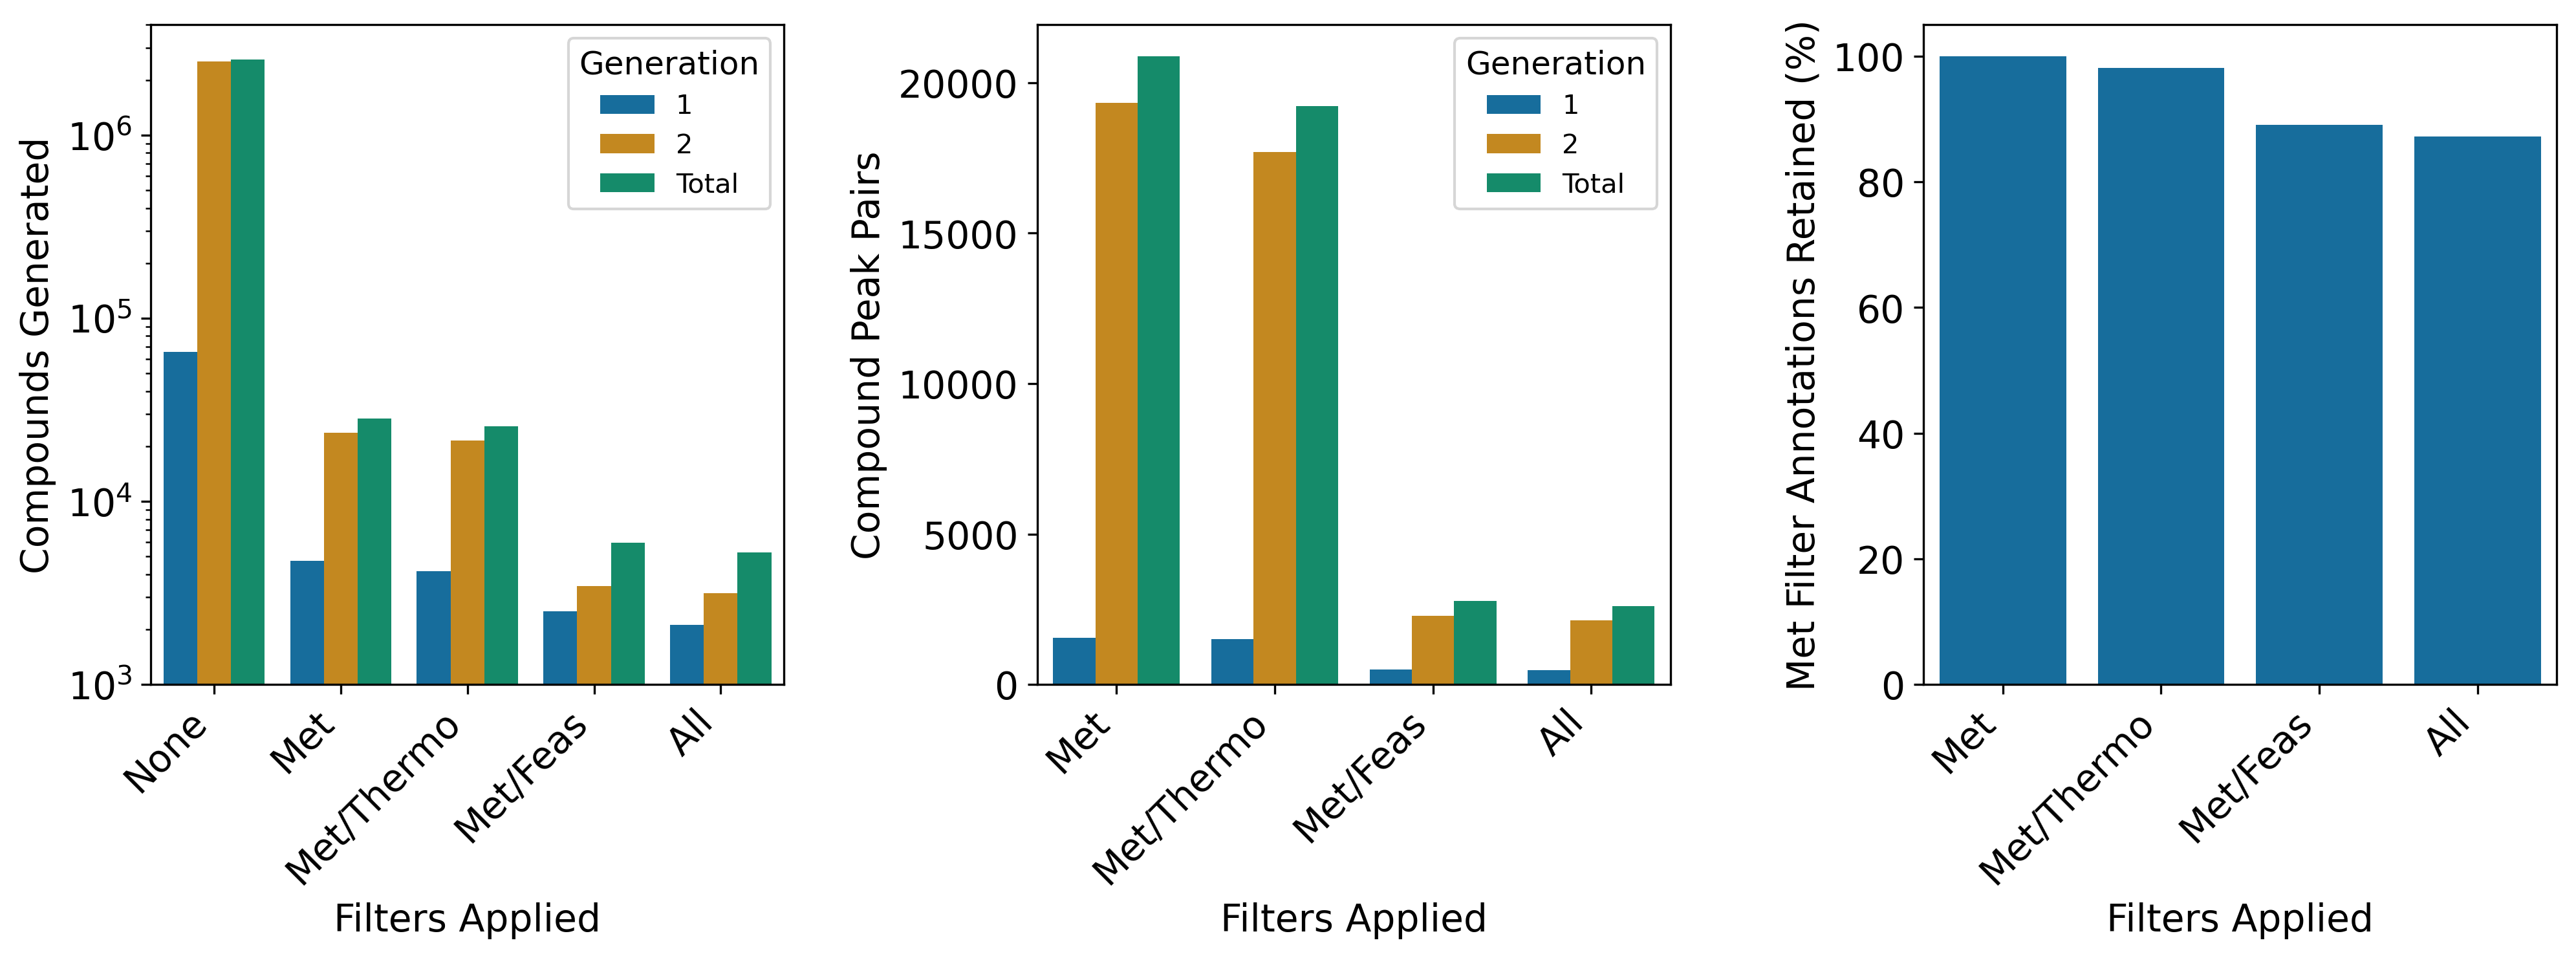

In [25]:
##########################################
# Base plot options
fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=300)
fig.subplots_adjust(wspace=.4)

##########################################
palette = "colorblind"

#########################################
# Plot compound generation plot
df = count_df[count_df.Generation != 0]
# df = df[~df["Filter"].isin(["Thermodynamic/Met", "All"])]

g = sns.barplot(
    x="Filter",
    y="compounds",
    hue="generation",
    palette=palette,
    data=df_cpd_count,
    ax=axs[0],
    order=["None", "Metabolomic", "Thermodynamic/Met", "Feasibility/Met", "All"]
)

g.set(yscale="log", ylim=(10E2, 4*1E6))
g.legend(title="Generation")
g.set_ylabel("Compounds Generated")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["None", "Met", "Met/Thermo", "Met/Feas",  "All"])

##########################################
# Plot compound generation plot
df = count_df[count_df.Generation != 0]
# df = df[~df["Filter"].isin(["Thermodynamic/Met", "All"])]

g = sns.barplot(
    x="Filter",
    y="counts",
    hue="Generation",
    palette=palette,
    data=df,
    ax=axs[1]
)


g.set_ylabel("Compound Peak Pairs")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["Met","Met/Thermo", "Met/Feas",  "All"])

############################################################
# Plot hits 
df = peak_count_df[peak_count_df.Generation != 0]
df = df[df["Generation"] == "Total"]
df["counts_per"] = df["counts"] / max(df["counts"]) * 100

g = sns.barplot(
    x="Filter",
    y="counts_per",
    hue="Generation",
    palette=palette,
    data=df,
    ax=axs[2]
)
# g.set(yscale="log", ylim=(10E-2, 10E1))
g.set_ylabel("Met Filter Annotations Retained (%)")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["Met","Met/Thermo", "Met/Feas",  "All"])
g.get_legend().remove()

fig.autofmt_xdate(rotation=45)
fig.savefig("../../figures/fig6_filters_totalPA_scaled.png", bbox_inches="tight", dpi=300)

# fig.tight_layout()

# Generations + Unique

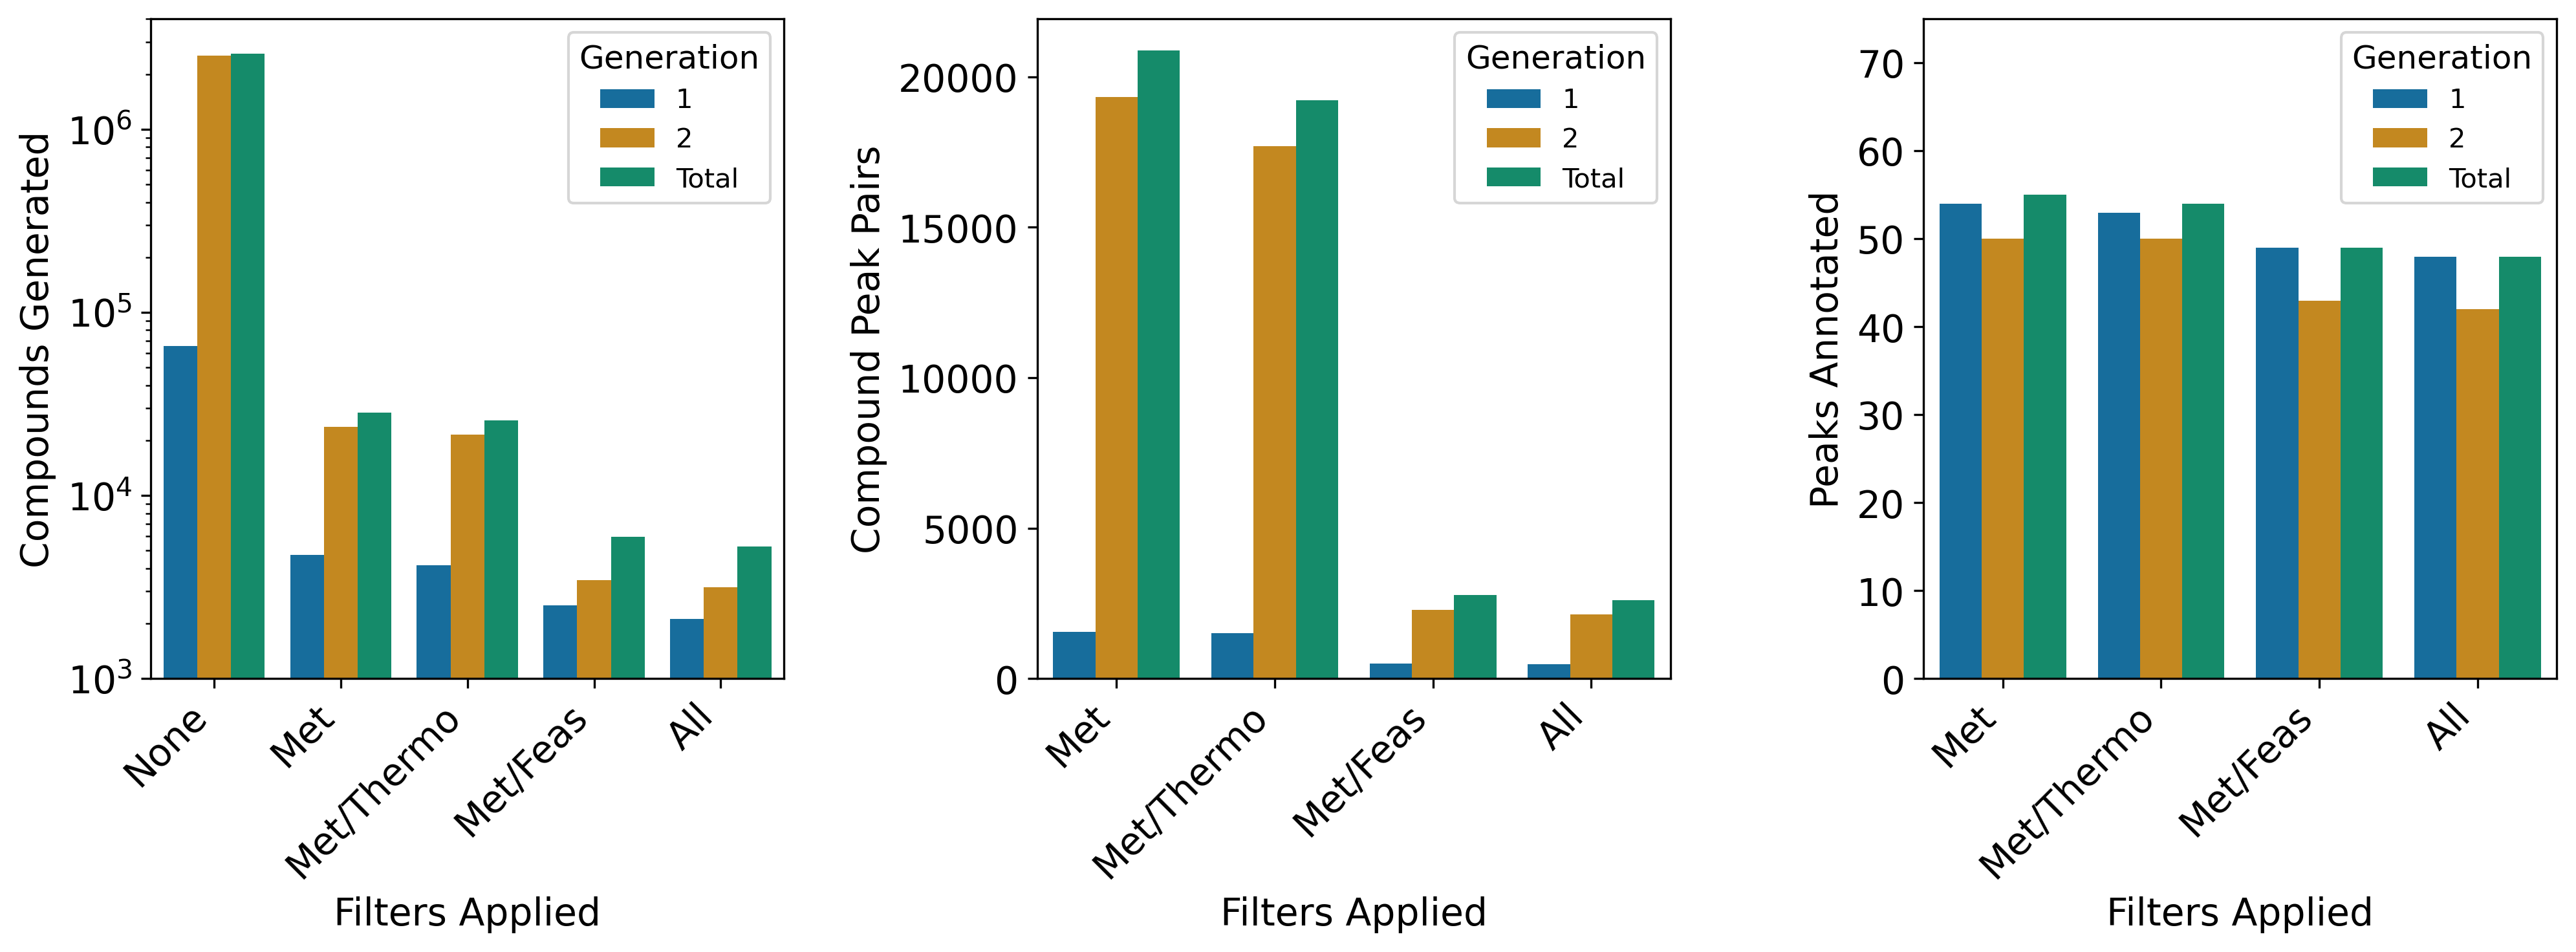

In [177]:
##########################################
# Base plot options
fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=300)
fig.subplots_adjust(wspace=.4)

##########################################
palette = "colorblind"

#########################################
# Plot compound generation plot
df = count_df[count_df.Generation != 0]
# df = df[~df["Filter"].isin(["Thermodynamic/Met", "All"])]

g = sns.barplot(
    x="Filter",
    y="compounds",
    hue="generation",
    palette=palette,
    data=df_cpd_count,
    ax=axs[0],
    order=["None", "Metabolomic", "Thermodynamic/Met", "Feasibility/Met", "All"]
)

g.set(yscale="log", ylim=(10E2, 4*1E6))
g.legend(title="Generation")
g.set_ylabel("Compounds Generated")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["None", "Met", "Met/Thermo", "Met/Feas",  "All"])

##########################################
# Plot compound generation plot
df = count_df[count_df.Generation != 0]
# df = df[~df["Filter"].isin(["Thermodynamic/Met", "All"])]

g = sns.barplot(
    x="Filter",
    y="counts",
    hue="Generation",
    palette=palette,
    data=df,
    ax=axs[1]
)


g.set_ylabel("Compound Peak Pairs")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["Met","Met/Thermo", "Met/Feas",  "All"])

############################################################
# Plot hits 
df = peak_count_df[peak_count_df.Generation != 0]
# df = df[df["Generation"] == "Total"]

g = sns.barplot(
    x="Filter",
    y="counts",
    hue="Generation",
    palette=palette,
    data=df,
    ax=axs[2]
)
g.set(ylim=(0, 75))
g.set_ylabel("Peaks Annotated")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["Met","Met/Thermo", "Met/Feas",  "All"])
# g.legend(["1", "2", "Total"], title="Generation")

fig.autofmt_xdate(rotation=45)
fig.savefig("../../figures/fig6_filters_genPA.png", bbox_inches="tight", dpi=300)

# fig.tight_layout()

# Gens for Peaks Annotated

In [178]:

from collections import defaultdict # All
runs = [("Metabolomic", pk), ("Thermodynamic/Met", pk_thermodynamics), ("Feasibility/Met", pk_feasibility), ("All", pk_all_filters)]

count_dict = dict()
peak_dict = dict()
peak_count_dict = dict()

for run_name, run_pk in runs:
    count_dict[run_name] = {}
    hits_dict = defaultdict(set)
    for cpd in run_pk.compounds.values():
        
        if cpd["_id"].startswith("C"):
            matched_peaks = cpd.get("Matched_Peak_IDs", [])
            count_dict[run_name][cpd["Generation"]] = count_dict[run_name].get(cpd["Generation"], 0) + len(matched_peaks)

            for peak in matched_peaks:
                hits_dict[cpd["Generation"]].add(peak)

    unique_gen2 = hits_dict[2] - hits_dict[1]
    peak_dict[run_name] = hits_dict
    # peak_count_dict[run_name] = {k:len(v) for k, v in hits_dict.items()}
    peak_count_dict[run_name] = {1:len(hits_dict[1]), 2:len(hits_dict[2]-hits_dict[1])}
    peak_count_dict[run_name]["Total"] = len(peak_dict[run_name][1].union(peak_dict[run_name][2]))
    cumsum = 0
    for val in count_dict[run_name].values():
        cumsum += val
    
    count_dict[run_name]["Total"] = cumsum


count_df = pd.DataFrame.from_dict(count_dict).T.reset_index().rename(columns={"index": "Filter"})
count_df = pd.melt(count_df, id_vars=["Filter"], value_vars=[0, 1, 2, "Total"], var_name="Generation", value_name="counts")

peak_count_df = pd.DataFrame.from_dict(peak_count_dict).T.reset_index().rename(columns={"index": "Filter"})
peak_count_df = pd.melt(peak_count_df, id_vars=["Filter"], value_vars=[1, 2, "Total"], var_name="Generation", value_name="counts")

/var/folders/mn/k32kn37x5ldgpp51c6cdmkpm0000gn/T/ipykernel_16042/1093256671.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels([0, 10, 20, 30, 40, 50, 60])


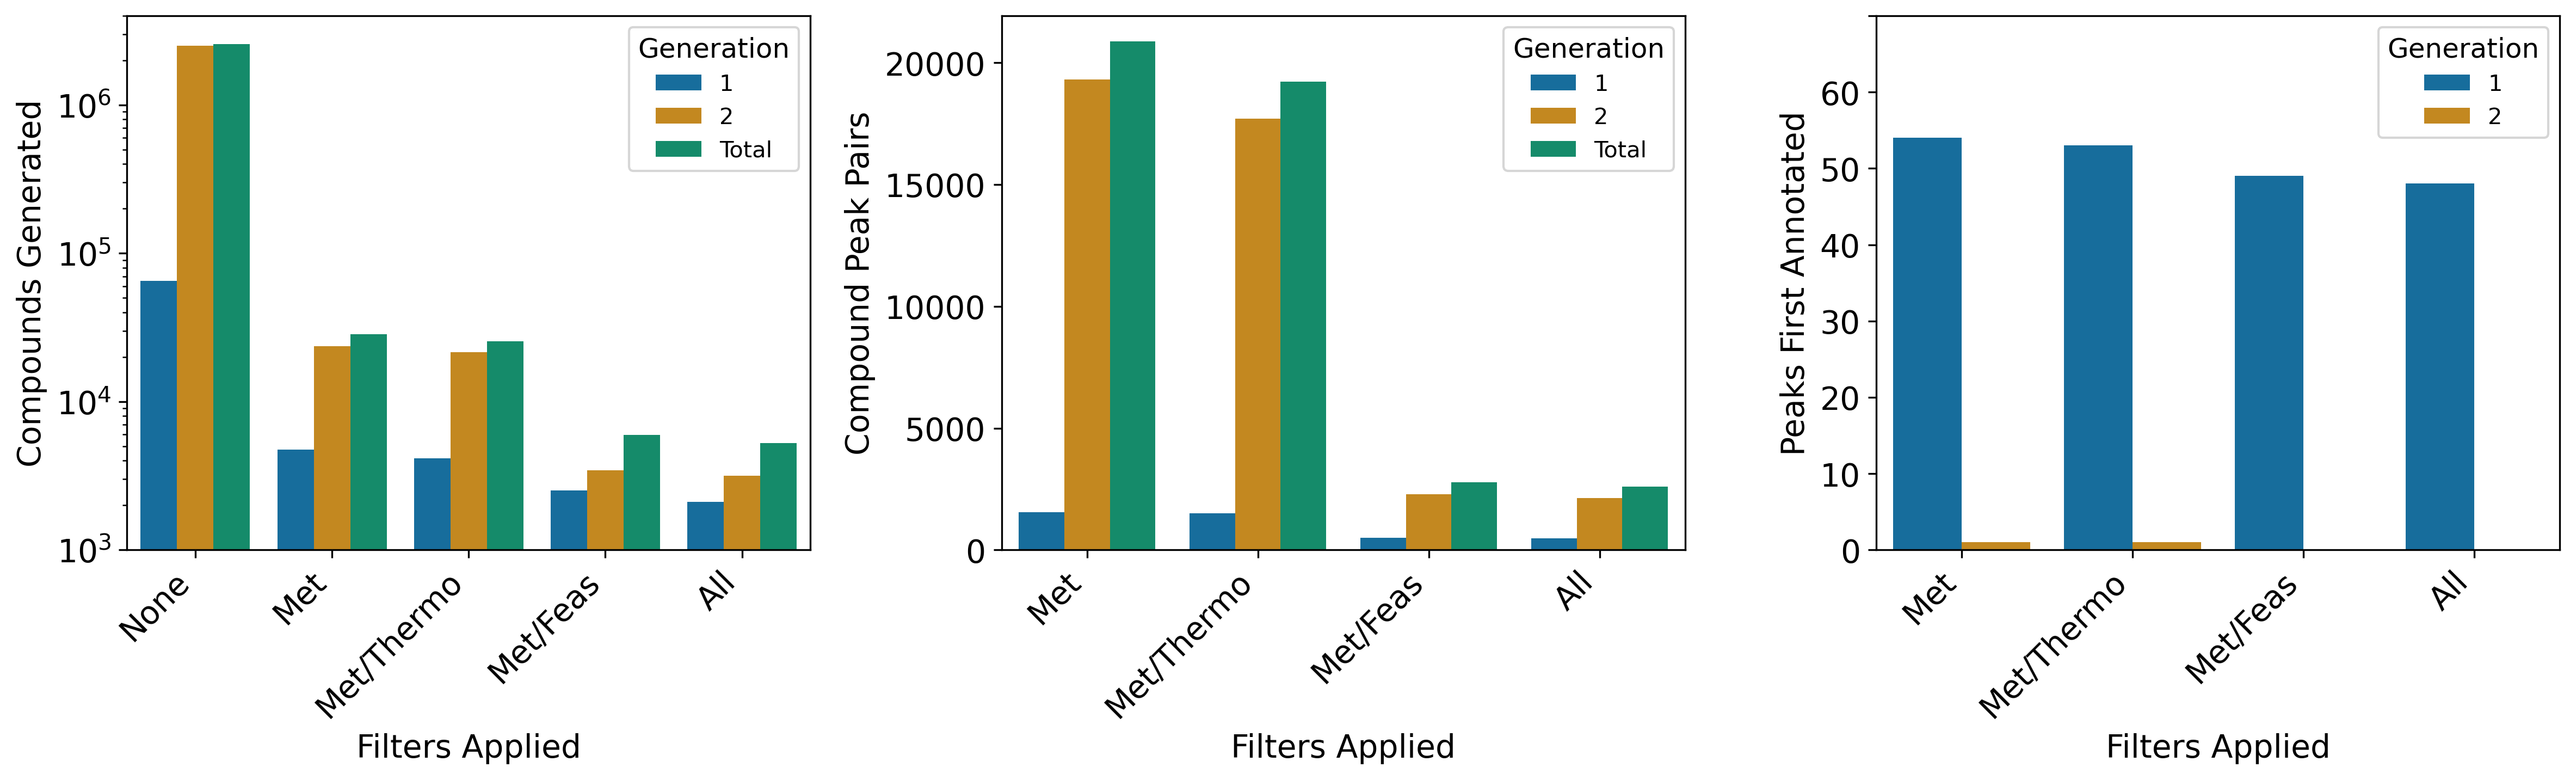

In [179]:
##########################################
# Base plot options
fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=300)
fig.subplots_adjust(wspace=.4)

##########################################
palette = "colorblind"

#########################################
# Plot compound generation plot
df = count_df[count_df.Generation != 0]
# df = df[~df["Filter"].isin(["Thermodynamic/Met", "All"])]

g = sns.barplot(
    x="Filter",
    y="compounds",
    hue="generation",
    palette=palette,
    data=df_cpd_count,
    ax=axs[0],
    order=["None", "Metabolomic", "Thermodynamic/Met", "Feasibility/Met", "All"]
)

g.set(yscale="log", ylim=(10E2, 4*1E6))
g.legend(title="Generation")
g.set_ylabel("Compounds Generated")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["None", "Met", "Met/Thermo", "Met/Feas",  "All"])

##########################################
# Plot compound generation plot
df = count_df[count_df.Generation != 0]
# df = df[~df["Filter"].isin(["Thermodynamic/Met", "All"])]

g = sns.barplot(
    x="Filter",
    y="counts",
    hue="Generation",
    palette=palette,
    data=df,
    ax=axs[1]
)


g.set_ylabel("Compound Peak Pairs")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["Met","Met/Thermo", "Met/Feas",  "All"])

############################################################
# Plot hits 
df = peak_count_df[peak_count_df.Generation != 0]
df = df[df["Generation"] != "Total"]

g = sns.barplot(
    x="Filter",
    y="counts",
    hue="Generation",
    palette=palette,
    data=df,
    ax=axs[2]
)
g.set(ylim=((0, 70)))
g.set_ylabel("Peaks First Annotated")
g.set_xlabel("Filters Applied")
g.set_xticklabels(["Met","Met/Thermo", "Met/Feas",  "All"])
g.set_yticklabels([0, 10, 20, 30, 40, 50, 60])

fig.autofmt_xdate(rotation=45)
fig.savefig("../../figures/fig6_filters_uniqPA.png", bbox_inches="tight", dpi=300)

fig.tight_layout()

In [182]:
df_cpd_count

,Filter,generation,compounds
0,Metabolomic,1,4757
1,Metabolomic,2,23671
2,Metabolomic,Total,28428
3,Thermodynamic/Met,1,4155
4,Thermodynamic/Met,2,21473
5,Thermodynamic/Met,Total,25628
6,Feasibility/Met,1,2518
7,Feasibility/Met,2,3455
8,Feasibility/Met,Total,5973
9,All,1,2115


In [26]:
from rdkit.Chem import AllChem